In [48]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, math, os, sys

from typing import List, Tuple, Dict, Literal

In [2]:
df = pd.read_csv('EEG_recording_2025-10-04-04.44.36.csv')

In [27]:
SENSORS = ['TP9', 'AF7', 'AF8', 'TP10']

In [50]:
def get_trigger(history: np.ndarray, current: float, stds: float = 3.0) -> Literal['none', 'positive', 'negative']:

    mean = history.mean()
    std = history.std()

    current_stds = (current - mean) / std

    if abs(current_stds) > stds:

        if current_stds > 0:

            return 'positive'
        
        else:

            return 'negative'
        
    return 'none'

In [107]:
def plot_sensors(data: pd.DataFrame, r: slice = slice(0, -1), history_len: int = 200, trigger_stds: float = 1.75, min_trigger_len: int = 5, min_stretch_gap: int = 10) -> 'Axis':
    
    fig, axs = plt.subplots(len(SENSORS), 1, figsize=(12, 2.5 * len(SENSORS)))
    
    axs = axs.flatten()

    sensor_trigger_history = []

    # Generate trigger bounds
    for s in SENSORS:

        mean, std = rolling_stats(
                data[s].to_numpy()[r], window_size=history_len
            )

        sensor_trigger_history.append(
            (
                mean - std * trigger_stds, mean + std * trigger_stds
            )
        )

    # Adjust time stamps to zero
    ts = data['timestamps'][r] - data['timestamps'][r].min()
    
    # Color palette for different sensors
    colors = plt.cm.tab10(range(len(SENSORS)))
    
    for i, (s, sh, ax) in enumerate(zip(SENSORS, sensor_trigger_history, axs)):

        d = data[s][r]

        up_highlight = np.full_like(d, fill_value=np.nan)
        down_highlight = np.full_like(d, fill_value=np.nan)

        # Highlight sections outside of bounds
        min_b, max_b = sh

        up_highlight[max_b < d] = d[max_b < d]
        down_highlight[min_b > d] = d[min_b > d]
        
        ax.plot(
            ts,
            d,
            color=colors[i],
            linewidth=2,
            alpha=0.8
        )

        ax.plot(ts, min_b, color='red', alpha=0.5, linestyle='--', linewidth=1)
        ax.plot(ts, max_b, color='blue', alpha=0.5, linestyle='--', linewidth=1)

        ax.plot(ts, up_highlight, color='green', linewidth=2.5)
        ax.plot(ts, down_highlight, color='green', linewidth=2.5)
        
        # Find continuous stretches of non-NaN values
        def find_stretches(highlight_array, min_len, min_gap):
            """Find continuous stretches of non-NaN values >= min_len"""
            stretches = []
            start = None
            
            for i in range(len(highlight_array)):
                if not np.isnan(highlight_array[i]):
                    if start is None:
                        start = i
                else:
                    if start is not None:
                        length = i - start
                        if length >= min_len:
                            stretches.append((start, i - 1, length))
                        start = None
            
            # Handle case where stretch extends to end
            if start is not None:
                length = len(highlight_array) - start
                if length >= min_len:
                    stretches.append((start, len(highlight_array) - 1, length))
            
            # Filter out stretches that are too close together
            if len(stretches) <= 1:
                return stretches
            
            filtered_stretches = [stretches[0]]
            for start_idx, end_idx, length in stretches[1:]:
                prev_end = filtered_stretches[-1][1]
                # Check if gap between previous stretch end and current stretch start is large enough
                if start_idx - prev_end >= min_gap:
                    filtered_stretches.append((start_idx, end_idx, length))
                else:
                    # Merge with previous stretch if too close
                    prev_start = filtered_stretches[-1][0]
                    new_length = end_idx - prev_start + 1
                    filtered_stretches[-1] = (prev_start, end_idx, new_length)
            
            return filtered_stretches
        
        # Add tags for upper threshold violations
        up_stretches = find_stretches(up_highlight, min_trigger_len, min_stretch_gap)
        for start_idx, end_idx, length in up_stretches:
            ax.text(
                ts.iloc[start_idx], 
                d.iloc[start_idx],
                f'▲ HIGH ({length})',
                fontsize=9,
                fontweight='bold',
                color='darkred',
                ha='left',
                va='bottom',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='red', alpha=0.8)
            )
        
        # Add tags for lower threshold violations
        down_stretches = find_stretches(down_highlight, min_trigger_len, min_stretch_gap)
        for start_idx, end_idx, length in down_stretches:
            ax.text(
                ts.iloc[start_idx],
                d.iloc[start_idx],
                f'▼ LOW ({length})',
                fontsize=9,
                fontweight='bold',
                color='darkblue',
                ha='left',
                va='top',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='blue', alpha=0.8)
            )
        
        # Styling
        ax.set_ylabel(s, fontsize=11, fontweight='bold')
        ax.set_xlabel('Time (s)' if i == len(SENSORS) - 1 else '', fontsize=10)
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Format x-axis for better readability
        ax.tick_params(axis='both', labelsize=9)
        
    plt.suptitle('Sensor Data with Anomaly Detection', fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    return axs

In [111]:
len(df)

14136

array([<Axes: ylabel='TP9'>, <Axes: ylabel='AF7'>, <Axes: ylabel='AF8'>,
       <Axes: xlabel='Time (s)', ylabel='TP10'>], dtype=object)

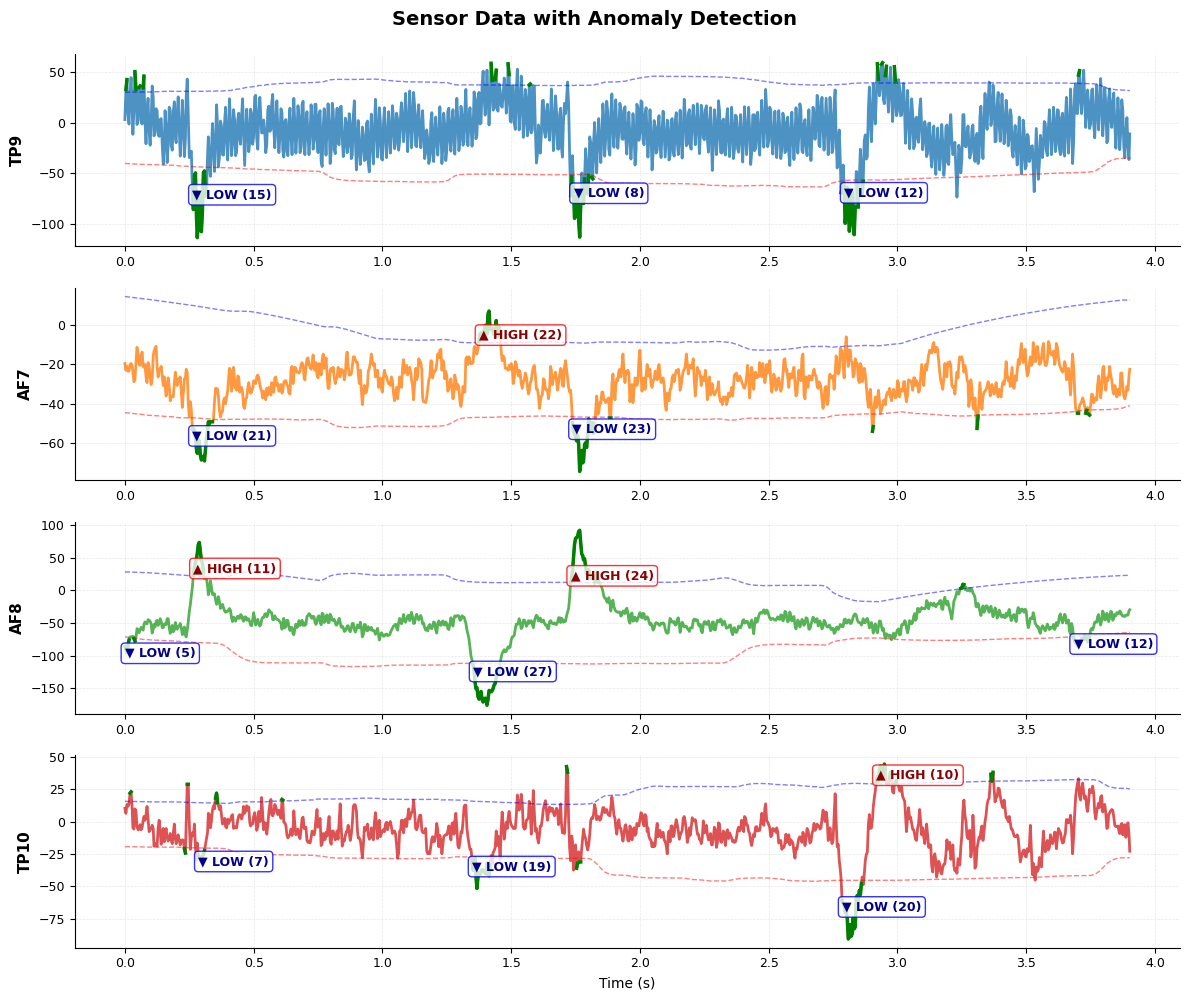

In [125]:
start: int = 5000
bound: int = 1000

plot_sensors(df, r=slice(start, start + bound), history_len=bound // 2)

array([<Axes: ylabel='TP9'>, <Axes: ylabel='AF7'>, <Axes: ylabel='AF8'>,
       <Axes: xlabel='Time (s)', ylabel='TP10'>], dtype=object)

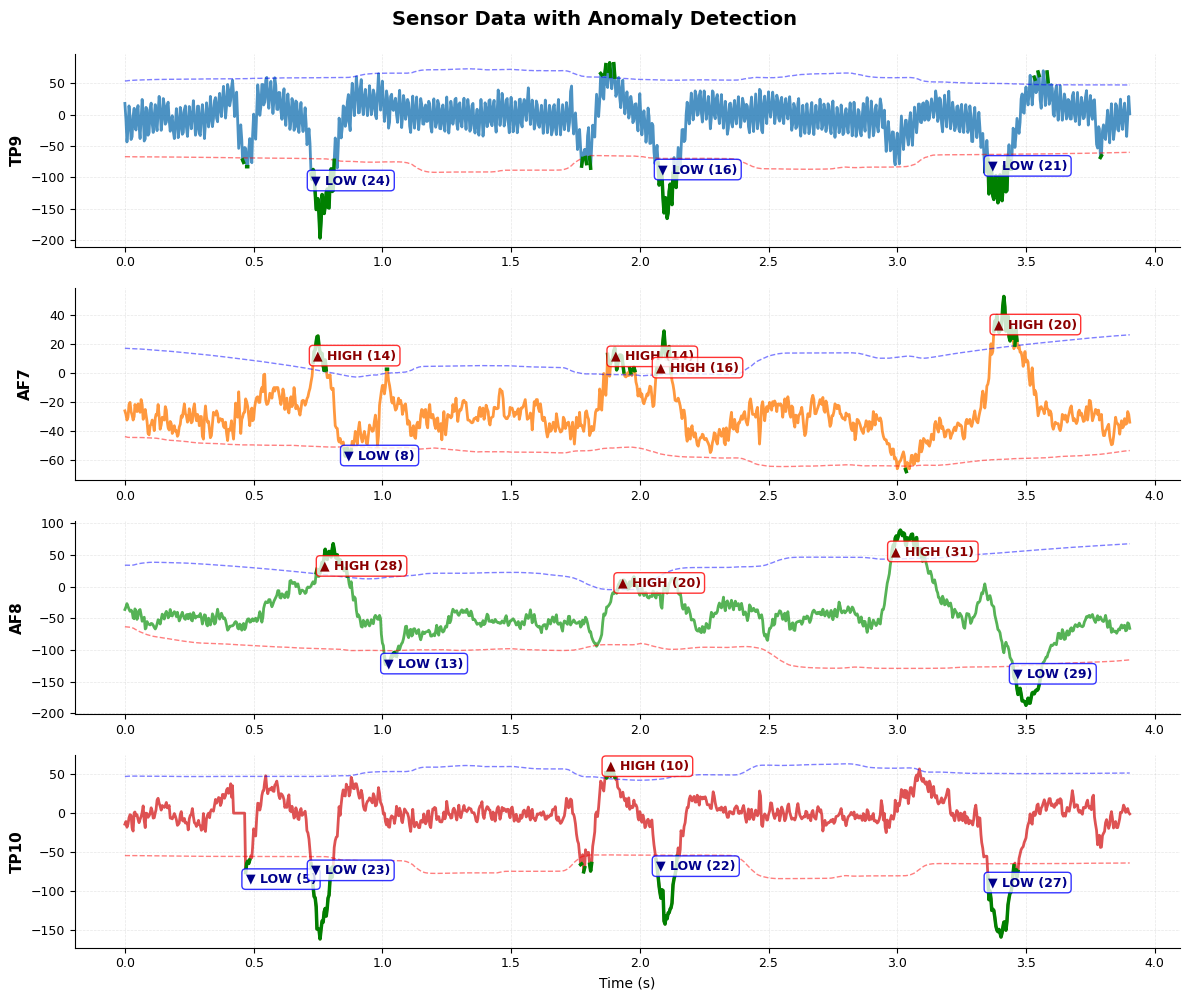

In [124]:
start: int = 6000
bound: int = 1000

plot_sensors(df, r=slice(start, start + bound), history_len=bound // 2)